Use Vertex AI multimodal to ask questions in a chatbot to generate
* caption
* description
* title
* rating
* category

of a product photograph

In [4]:
%pip install --upgrade --user google-cloud-aiplatform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 35.9 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

# Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, you will need to authenticate your environment. To do this, run the new cell below. This step is not required if you are using Vertex AI Workbench.

In [1]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

In [2]:
# Define project information
from google.colab import userdata
PROJECT_ID = userdata.get('VERTEX_AI_PROJECT_ID')
LOCATION = "asia-east2"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

# Create a Gemini 1.5 Flash model

- maximum output tokens is 1024
- temperature is 1 such that the generated content is creative
- top_p is 0.95.  When the total probability of the tokens exceeds 0.95, the tokens are used for text generation

In [23]:
from vertexai.generative_models import GenerativeModel, Part
import vertexai.preview.generative_models as generative_models
import json
from vertexai.preview.vision_models import Image

generation_config = {
    "max_output_tokens": 1024,
    "temperature": 1,
    "top_p": 0.95,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}

model = GenerativeModel(
    "gemini-1.5-flash-001",
    system_instruction=["""You are an expert in generating fake data for an API in English."""],
    safety_settings=safety_settings,
    generation_config=generation_config
)

print(model)

# Start conversation
- Upload a image from gCloud Storage
- Create a part from the image


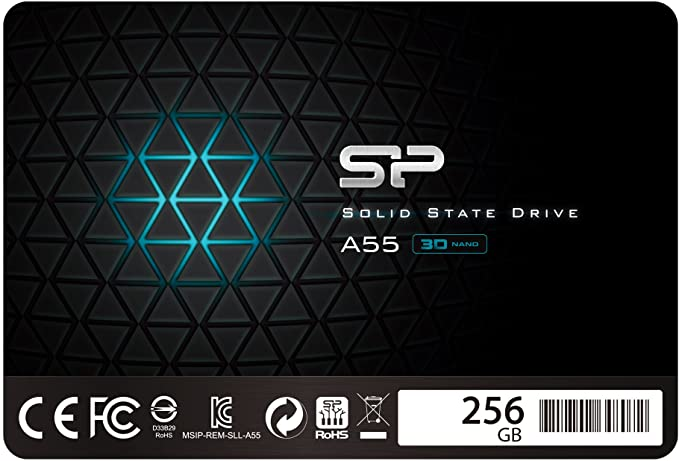

In [24]:


file_path = "gs://fake-store-bucket/71kWymZ+c+L._AC_SX679_.jpg"  # @param {type:"string"}

# Load the image file as Image object
image = Image.load_from_file(file_path)
image.show()

imagePart = Part.from_uri(
    mime_type="image/jpeg",
    uri=file_path)

- Start a conversation
- Prompt the chatbot to generate an image caption

In [26]:
chat = model.start_chat()

caption = chat.send_message([imagePart, """Please provide image captioning in less than 10 words in English."""]).candidates[0].content.parts[0].text
print(caption)

A 256GB Solid State Drive from SP.


- Prompt the chatbot to generate the category

In [27]:
category = chat.send_message(["""Please pick the most appropriate category from electronics, jewelery, men\'s clothing, and women\'s clothing.  Give me the category and nothing else."""]).candidates[0].content.parts[0].text
print(category)

electronics 



- Prompt the chatbot to generate a title in less than 25 words
- Prompt the chatbot to generate a description based on the category and title in one paragraph. The description should be less than 300 words and in English


In [28]:
title = chat.send_message(["""The category of the product is {category}. Please provide an English title in less than 30 words."""]).candidates[0].content.parts[0].text
print(title)

description = chat.send_message(["""Please provide the description of the product based on the above category and title in one paragraph. The description should be less than 300 words."""]).candidates[0].content.parts[0].text
print(description)

SP A55 3D NAND 256GB Solid State Drive 

The SP A55 3D NAND 256GB Solid State Drive is a high-performance storage solution designed to enhance your computer's speed and responsiveness.  Featuring 3D NAND flash technology, this drive provides a significant boost in read and write speeds compared to traditional hard disk drives (HDDs). The 256GB capacity offers ample storage for your operating system, applications, and important files. With its compact size and low power consumption, the A55 is ideal for both desktop and laptop computers.  Experience faster boot times, quicker program launches, and seamless multitasking with this reliable and efficient SSD. 



- Prompt the chatbot to generate a rating between 0 and 5 where 0 is the lowest and 5 is the highest. At most 1 decimal place is allowed.
- Print the JSON object out

In [30]:
ratingResponse = chat.send_message(["""Please generate a rating between 0 and 5 where 0 is the lowest rating and 5 is the highest rating. At most 1 decimal place is allowed."""])
rating = ratingResponse.candidates[0].content.parts[0].text
print(rating)

object = {
    "caption": caption,
    "description": description,
    "title": title,
    "rating": rating,
    "category": category
}

print(json.dumps(object, indent=2))

4.2 

{
  "caption": "A 256GB Solid State Drive from SP.",
  "description": "The SP A55 3D NAND 256GB Solid State Drive is a high-performance storage solution designed to enhance your computer's speed and responsiveness.  Featuring 3D NAND flash technology, this drive provides a significant boost in read and write speeds compared to traditional hard disk drives (HDDs). The 256GB capacity offers ample storage for your operating system, applications, and important files. With its compact size and low power consumption, the A55 is ideal for both desktop and laptop computers.  Experience faster boot times, quicker program launches, and seamless multitasking with this reliable and efficient SSD. \n",
  "title": "SP A55 3D NAND 256GB Solid State Drive \n",
  "rating": "4.2 \n",
  "category": "electronics \n"
}


# Put everything together

- Put the conversation in a function

In [ ]:
def generateData(file_path):
  generation_config = {
    "max_output_tokens": 1024,
    "temperature": 1,
    "top_p": 0.95,
  }

  safety_settings = {
      generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
      generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
      generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
      generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
  }

  model = GenerativeModel(
      "gemini-1.5-flash-001",
      system_instruction=["""You are an expert in generating fake data for an API in English."""],
      safety_settings=safety_settings,
      generation_config=generation_config
  )

  imagePart = Part.from_uri(
    mime_type="image/jpeg",
    uri=file_path)

  caption = chat.send_message([imagePart, """Please provide image captioning in less than 10 words in English."""]).candidates[0].content.parts[0].text
  category = chat.send_message(["""Please pick the most appropriate category from electronics, jewelery, men\'s clothing, and women\'s clothing.  Give me the category and nothing else."""]).candidates[0].content.parts[0].text
  title = chat.send_message(["""The category of the product is {category}. Please provide an English title in less than 30 words."""]).candidates[0].content.parts[0].text
  description = chat.send_message(["""Please provide the description of the product based on the above category and title in one paragraph. The description should be less than 300 words."""]).candidates[0].content.parts[0].text
  rating = chat.send_message(["""Please generate a rating between 0 and 5 where 0 is the lowest rating and 5 is the highest rating. At most 1 decimal place is allowed."""]).candidates[0].content.parts[0].text

  return {
      "catpion": caption,
      "description": description,
      "title": title,
      "rating": rating,
      "category": category
  }


data = generateData('gs://fake-store-bucket/71-3HjGNDUL._AC_SY879._SX._UX._SY._UY_.jpg')
formatted_json = json.dumps(data, indent=2)
print(formatted_json)

In [ ]:
data = generateData('gs://fake-store-bucket/61sbMiUnoGL._AC_UL640_QL65_ML3_.jpg')
formatted_json = json.dumps(data, indent=2)
print(formatted_json)